# Table of Contents
1. [Introduction](#1-introduction)
2. [Reading data](#2-reading-data)
    - 2.1 [File Structure](#21-file-structure)
    - 2.2 [Raw Data](#22-raw-data)
3. [Integrate Data](#3-integrate-data)
    - 3.1 [Determine Degree of Symmetry](#31-determine-degree-of-symmetry-azimuthalpolar-integration)
    - 3.2 [Radial integration](#32-radial-integration)
    - 3.3 [Reshape](#33-reshape)
        - 3.3.1 [Plot Intensity on sample geometry](#331-plotting-intensity-on-sample-geometry-all-images)
4. [Curve Fitting](#4-curve-fitting)
    - 4.1 [Removing Background Noise](#41-removing-background-noise)
    - 4.1.1 [Plot Data Without Background Noise](#42-plot-data-without-background-noise)
    - 4.2 [Fit Noise Free Data To Some Function](#43-fit-nosie-free-data-to-some-function)
    - 4.3 [Plot Fitted Data](#44-plot-fitted-data)

# 1 Introduction
Some information about SAXS/WAXS and the experiments.

# 2 Reading data


## 2.1 File structure
The data we have at FORMAX is gathered by two sensors.

    lambda, which measures the Wide Angle X-ray Scattering (WAXS)
    eiger, which measures the Small Angle X-ray Scattering (SAXS)

The sensors measure the number of photons hitting each pixel for a given exposure time, This is the raw data.

For each scan, there are three files that are stored as HDF5 files in the raw/ folder, which houses this data:

    scan-xxxx.h5: The master file for the scan, containing useful metadata for the scan.
    scan-xxxx_lambda.h5: The data from the WAXS scan.
    scan-xxxx_eiger.h5: The data from the SAXS scan.

Let us begin by examining the collection of samples and select one of them.

The name nomenclature is:  SampleNumber_DogboneType_Direction_RelativeHumidity(RH)

The SampleNumber (also referred to as scan number) is connected to the data files (xxxx above), DogboneType signifies the shape of the sample cutout, direction is either Machine Direction (MD) or Cross Direction (CD), and RelativeHumidity is a measure of how wet the sample is.

In the current version of this notebook, sample number 35 is pre-selected. If another is selected, subsequent code cells must be run again.

Note: when selecting scan number, do not select samples labeled with "Alignment" or "Realignment" as these are not complete scans, rather part of the set-up of the experiment.

In [1]:
import h5py
import os
import hdf5plugin
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import matplotlib.ticker as mticker
from ipywidgets import interact, widgets
from matplotlib import colors as mcolors
from matplotlib.ticker import FuncFormatter
from scipy import fft
from scipy import signal
from scipy.signal import find_peaks, savgol_filter
from scipy.stats import norm
from scipy.optimize import curve_fit

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [2]:
def calculate_y_limits(data, padding=0.1):
    """
    Calculate y-axis limits with padding for a given dataset.

    Parameters
    ----------
    data : np.ndarray
        The intensity data to calculate limits for.
    padding : float, optional
        Fractional padding to add to the min and max values (default: 0.1).

    Returns
    -------
    tuple
        Tuple of (y_min, y_max) with applied padding.
    """
    y_min = data.min() - padding * abs(data.min())
    y_max = data.max() + padding * abs(data.max())
    return y_min, y_max

def q_to_d(q):
    """Convert q (Å⁻¹) to d (Å), excluding zero or near-zero values."""
    q_safe = np.clip(q, 1e-6, None)  # Replace q <= 0 with a small positive value
    return 2 * np.pi / q_safe
    
def d_to_q(d):
    """Convert d (Å) to q (Å⁻¹), excluding zero or near-zero values."""
    d_safe = np.clip(d, 1e-6, None)
    return 2 * np.pi / d_safe

In [3]:
def select_sample():
    """
    Provides a widget interface for selecting a sample and scan number from the logbook CSV file.

    Returns
    -------
    tuple
        Selected sample name and scan number.
    """
    # Load the CSV file
    csv_path = "logbook_227.csv"
    logbook = pd.read_csv(csv_path, delimiter=";", skipinitialspace=True)

    # Clean up unnecessary columns
    logbook = logbook.drop(columns=[col for col in logbook.columns if "Unnamed" in col or "Name nomenclature" in col], errors='ignore')

    selected_sample = widgets.Output()
    selected_scan = widgets.Output()

    # Define sample selection widget
    def update_sample(sample_name):
        sample_rows = logbook[logbook["Name"] == sample_name]
        with selected_sample:
            selected_sample.clear_output()
            if not sample_rows.empty:
                display(sample_rows)

        # Update scan number dropdown options
        scan_dropdown.options = sample_rows["ScanNbr"].tolist()

    sample_dropdown = widgets.Dropdown(
        options=logbook["Name"].unique(),
        description="Sample:"
    )
    sample_dropdown.observe(lambda change: update_sample(change.new), names="value")

    # Define scan number selection widget
    def update_scan(scan_number):
        global scan_num
        scan_num = scan_number
        with selected_scan:
            selected_scan.clear_output()
            print(f"Selected Scan Number: {scan_number}")

    scan_dropdown = widgets.Dropdown(
        options=[],
        description="ScanNbr:"
    )
    scan_dropdown.observe(lambda change: update_scan(change.new), names="value")

    # Display widgets
    display(sample_dropdown)
    display(selected_sample)
    display(scan_dropdown)
    display(selected_scan)

    # Return the selected values
    return sample_dropdown, scan_dropdown

# Run Sample Selection Widget
scan_num = 35
sample_dropdown, scan_dropdown = select_sample()


Dropdown(description='Sample:', options=('Test_SD_MD_50', '01_SD_MD_50', '02_SD_MD_50', '02_DTH_MD_50', '03_DT…

Output()

Dropdown(description='ScanNbr:', options=(), value=None)

Output()

## 2.2 Raw Data
Let us visualize the raw data for a SAXS and WAXS sample corresponding to the selected scan number to get some idea of what we are working with.

We do this by constructing the file paths to the data files, then loading them to variables, finally plotting them. 

The SAXS data is rather straightforward, simply extract the data from the specified file. For the WAXS data, due to the experimental setup, the data is divided in 4 parts--one for each detector. The detectors are setup in a "windmill shape" where each detector is oriented at 90 degree angles from eachother--we need to restructure the data so that it reflects the geometry of the sample.

Each sample contain 3050 images (61 rows, 50 columns), each image corresponds to a point in the sample where the X-ray beam is shot through. The ordering of the images corresponds to a so called *snake scan*--starting in the top left of the sample, going right, then moving down to the next row moving left etc. 

<div style="text-align: center;">
    <img src="snake_scan.png" alt="Snake Scan" style="width: 15%; height: auto;">
    <p style="text-align: center;"><b>Figure 1:</b> Example of a snake scan.</p>
</div>

Image number 1525 is pre-selected which corresponds to a point close to the center of the sample. To select another point in the sample simply change the variable "image_idx" below. Also note that as it is set-up at the moment, if another sample (scan number) is selected above, the code cells below needs to be run again.

SAXS file path: /data/visitors/formax/20240661/2024102408/raw/scan-0035_eiger.h5
WAXS file path: /data/visitors/formax/20240661/2024102408/raw/scan-0035_lambda.h5

Loaded scan-0035_eiger.h5 (image 1525) to: saxs_data
Loaded scan-0035_lambda.h5 (image 1525) to: waxs_data



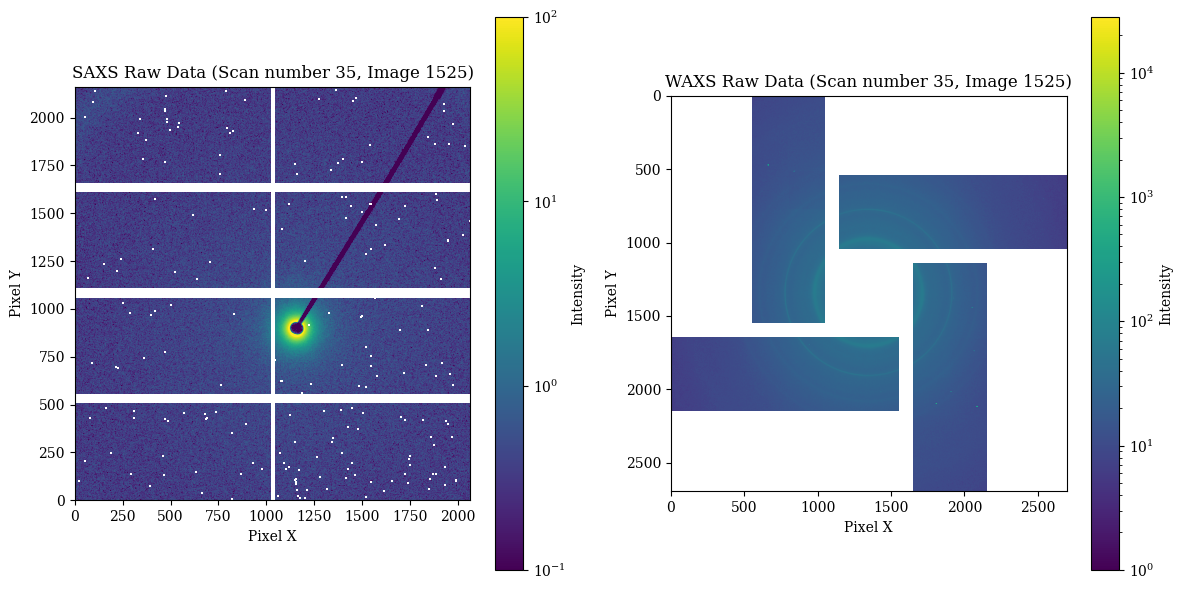

In [4]:
def construct_file_path(scan_number, method, raw=False, proposal=20240661, visit=2024102408):
    """
    Constructs the file path for SAXS or WAXS data files.

    Parameters
    ----------
    scan_number : int
        The scan number identifying the specific sample.
    method : str
        Scattering method used ('SAXS' or 'WAXS').
    raw : bool, optional
        If True, returns the path to the raw data file in Cartesian coordinates.
        If False, returns the path to the pre-processed file in polar coordinates.
    proposal : int, optional
        Proposal ID for the data collection (default: 20240661).
    visit : int, optional
        Visit ID for the data collection (default: 2024102408).

    Returns
    -------
    str
        Constructed file path to the desired data file.
    """
    detector_map = {"SAXS": "eiger", "WAXS": "lambda"}
    method_upper = method.upper()

    if method_upper not in detector_map:
        raise ValueError("Invalid method. Must be 'SAXS' or 'WAXS'.")

    detector = detector_map[method_upper]
    file_type = "raw" if raw else "process/azint"
    suffix = "" if raw else "_integrated"

    return f"/data/visitors/formax/{proposal}/{visit}/{file_type}/scan-{scan_number:04d}_{detector}{suffix}.h5"

def load_saxs_raw(filepath, image_idx):
    """
    Loads raw SAXS data from an HDF5 file for a specified image.

    Parameters
    ----------
    filepath : str
        Path to the SAXS HDF5 file.
    image_idx : int
        Index of the image to extract.

    Returns
    -------
    np.ndarray
        Extracted raw SAXS data with invalid values set to NaN.
    """
    with h5py.File(filepath, "r") as file:
        data = file["/entry/instrument/eiger/data"][image_idx, :, :].astype(np.float32)
        data[data > 1e9] = np.nan  # Mask invalid values
    return data

def load_waxs_raw(filepath, image_idx):
    """
    Loads and reconstructs raw WAXS data from an HDF5 file for a specified image.

    Parameters
    ----------
    filepath : str
        Path to the WAXS HDF5 file.
    image_idx : int
        Index of the image to extract.

    Returns
    -------
    np.ndarray
        Reconstructed WAXS data as a 2D array.
    """
    with h5py.File(filepath, "r") as file:
        full_shape = file["/entry/instrument/lambda/full_shape"][()]
        rotation = file["/entry/instrument/lambda/rotation"][()]
        x_positions = file["/entry/instrument/lambda/x"][()]
        y_positions = file["/entry/instrument/lambda/y"][()]
        data = file["/entry/instrument/lambda/data"][image_idx, :, :, :]

    # Initialize the full data array with NaNs where we will store the image
    full_data = np.full(full_shape, np.nan, dtype=np.float32)

    # Reconstruct the full image from the four modules
    for i in range(4):
        # Rotate each module's data
        rotated = np.rot90(data[i, :, :], k=-rotation[i] // 90)

        # Insert rotated data into full image
        x_start, y_start = x_positions[i], y_positions[i]
        x_end, y_end = x_start + rotated.shape[1], y_start + rotated.shape[0]
        full_data[y_start:y_end, x_start:x_end] = rotated

    return full_data

def plot_raw_data(data, method, scan_num, image_idx, ax=None):
    """
    Plots raw SAXS or WAXS data.

    Parameters
    ----------
    data : np.ndarray
        Raw data array to be plotted.
    method : str
        Scattering method ('SAXS' or 'WAXS').
    ax : matplotlib.axes.Axes, optional
        Axes object to plot on (default: None).
    image_idx : int
        Index of the image to plot.

    Returns
    -------
    matplotlib.image.AxesImage
        Image object created by the plot.
    """
    if ax is None:
        ax = plt.gca()

    # Set up plotting parameters 
    norm = mcolors.SymLogNorm(linthresh=1e-3, vmin=1e-1, vmax=1e2) if method.upper() == "SAXS" else mcolors.LogNorm()
    origin = "lower" if method.upper() == "SAXS" else "upper"

    
    im = ax.imshow(data, cmap="viridis", norm=norm, origin=origin)
    ax.set_title(f"{method.upper()} Raw Data (Scan number {scan_num}, Image {image_idx})")
    ax.set_xlabel("Pixel X")
    ax.set_ylabel("Pixel Y")
    plt.colorbar(im, ax=ax, label="Intensity")
    return im

# Example Usage
image_idx = 1525
saxs_path = construct_file_path(scan_num, "SAXS", raw=True)
waxs_path = construct_file_path(scan_num, "WAXS", raw=True)
print(f"SAXS file path: {saxs_path}")
print(f"WAXS file path: {waxs_path}")
print()

saxs_data = load_saxs_raw(saxs_path, image_idx)
waxs_data = load_waxs_raw(waxs_path, image_idx)
print(f'Loaded {os.path.basename(saxs_path)} (image {image_idx}) to: saxs_data')
print(f'Loaded {os.path.basename(waxs_path)} (image {image_idx}) to: waxs_data')
print()

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot_raw_data(saxs_data, "SAXS", scan_num, image_idx, ax=ax1)
plot_raw_data(waxs_data, "WAXS", scan_num, image_idx, ax=ax2)
plt.tight_layout()
plt.show()

# 3 Integrate Data
The data in this form is not directly useful for anything other than displaying the diffraction patterns, it needs to be processed for us to be able to continue the analysis. To understand the logic behind what is done with the data, let us go through some brief scattering theory.

The scattering behaviour of X-rays can be explained by Bragg's law

\begin{equation}
n\lambda = 2dsin(\theta), \tag{1}
\end{equation}

where $n$ is a positive integer, $\lambda$ the wavelength of X-rays, $d$ the so called repeating distance between structures in the sample and $2\theta$ the scattering angle. According to Bragg's law, intensity peaks in the diffraction pattern dirrectly correspond to a repeating unit in the material.

When studying diffraction patterns it is conventient to define a wave vector $\boldsymbol{q}$ as

\begin{equation}
\boldsymbol{q} = \boldsymbol{k}_0 - \boldsymbol{k}_1, \tag{2}
\end{equation}

where $\boldsymbol{k}_0$ is the primary wave vector of incoming X-rays that go through the sample without scattering and $\boldsymbol{k}_1$ the wave vector of scattered X-rays at an angle $2\theta$ from $\boldsymbol{k}_0$. When the primary wave is scattered elastically, the wavelength remain constant, thus the length of $\boldsymbol{k}_1$ must be equal to $\boldsymbol{k}_0$. The magnitude of $\boldsymbol{k}_0$ is determined by its wavelength number $|\boldsymbol{k}_0| = \frac{2\pi}{\lambda}$. We can then calculate the magnitude of the wave vector $\boldsymbol{q}$ (which is the radius from the center of our diffraction pattern) with the help of the law of cosines

\begin{equation}
|\boldsymbol{q}| = |\boldsymbol{k}_0 - \boldsymbol{k}_1| = \sqrt{ \boldsymbol{k}_0^2 + \boldsymbol{k}_1^2 - 2\boldsymbol{k}_0\boldsymbol{k}_1\text{cos}(2\theta) } = \sqrt{ 2(\frac{2\pi}{\lambda})^2 \cdot 2\text{sin}^2(\theta) } = \frac{4\pi\text{sin}(\theta)}{\lambda}, \tag{3}
\end{equation}

where the trigonometric identity $\text{cos}(2\theta) = 1 - 2\text{sin}^2(\theta)$ is used for the third equality.

By combining (1) and (3) we get a relationship between the repeating distance $d$ and $|\boldsymbol{q}|$ (referred to as $q$ from here on out)

\begin{equation}
d = \frac{2\pi}{q} \iff q = \frac{2\pi}{d}, \tag{4}
\end{equation}

where $n = 1$ since we in this case only look at the first occurance of the intensity peak. We see that $q$ is inversely proportional to the repeating distance.

The important thing to draw from the above math excursion is that since we have a direct relationship between $d$ and $q$, it would be nice if we could express our intensity data $I$ in terms of $q$. Since $q$ is the radial component of the diffraction images, it makes sense to convert the original $I(x,y)$ which is in Cartesian coordinates to 2D-polar coordinates $I(q, \phi)$, where $\phi\in[0,2\pi]$ is the azimuthal angle of $q$ ($^{\circ}$).

Luckily, this is done for us automatically for each scan at MAX IV. In addition to the conversion to polar coordinates, this data is also normalized for beam intensity fluctuations and corrected for polarization. The data is availible in the /process/azint/ folder with labels:

    scan-xxxx_lambda_integrated.h5: The transformed data from the WAXS scan.
    scan-xxxx_eiger_integrated.h5: The transformed data from the SAXS scan.


Let us now load the transformed data. Now all points (images) are loaded so that they can be used later. The function used to load the data only loads intensity data where values exists, there are a lot of "deadzones" due to the shape of the detectors.

Loaded scan-0035_eiger_integrated.h5 to: saxs_data
Loaded scan-0035_lambda_integrated.h5 to: waxs_data


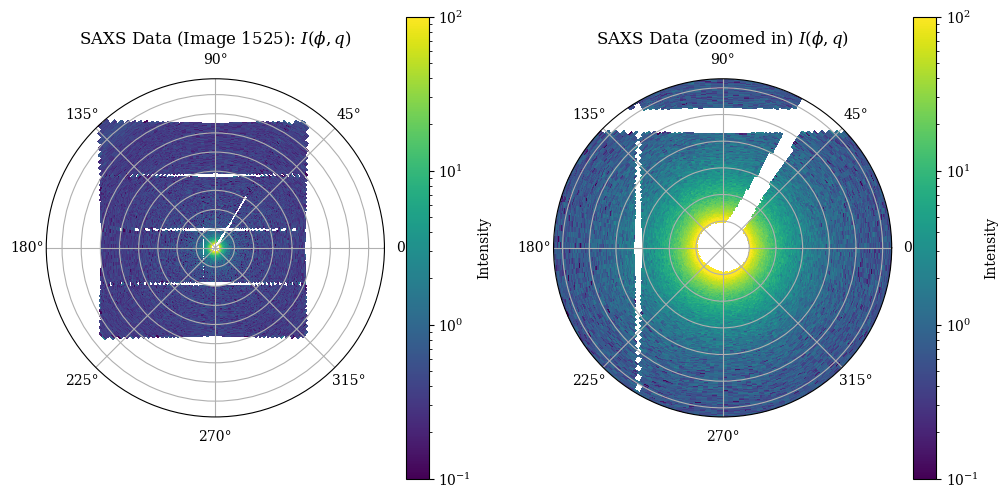

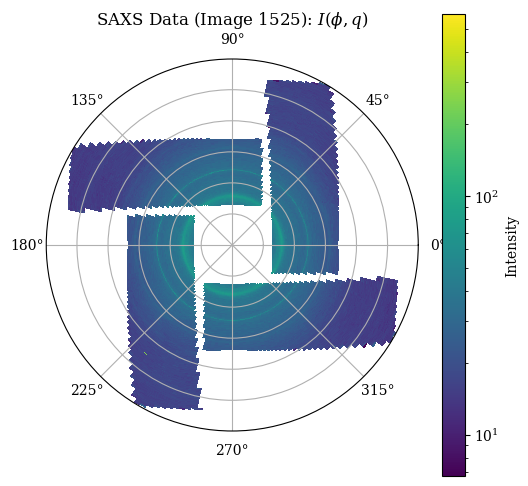

In [5]:
def load_transformed_data(scan_number, method):
    """
    Load the transformed data and return a dictionary with the relevant keys.

    Parameters
    ----------
    scan_number : int
        The scan number identifying the specific sample.
    method : str
        Scattering method used ('SAXS' or 'WAXS').

    Returns
    -------
    data : dict
        A dictionary containing the loaded data.

    Keys in the returned data dictionary:

    **From Integrated (Azimuthally Integrated) File**
    - 'I' : Cake plot from radial integration, shape (image, azimuthal angle, q)
    - 'azi' : Azimuthal bins (degrees)
    - 'q' : q-vector for integration (Å⁻¹)
    - 'mask_file' : File path for mask used in radial integration
    - 'norm' : Weights/norm sum for computing averages for integrated data
    - 'polarization_factor' : Polarization factor used for integration
    - 'poni_file' : File path for PONI file

    **From Raw (Master) File**
    - 'i_t' : Diode data, transmittance for 2D map
    - 'title' : Scan command from the instrument control software
    - 'shape' : Tuple indicating the shape of the scan (rows, columns)
    """
    detector_map = {"SAXS": "eiger", "WAXS": "lambda"}
    method_upper = method.upper()

    if method_upper not in detector_map:
        raise ValueError("Invalid method. Must be 'SAXS' or 'WAXS'.")

    detector = detector_map[method_upper]

    # Get the file path to the integrated data file
    file_path = construct_file_path(scan_number, method, raw=False)

    # Set up dictionary
    data = {}
    items = {
        'I': 'entry/data2d/cake',
        'q': 'entry/data1d/q',
        'azi': 'entry/data2d/azi',
        'mask_file': 'entry/azint/input/mask_file',
        'norm': 'entry/data2d/norm',
        'polarization_factor': 'entry/azint/input/polarization_factor',
        'poni_file': 'entry/azint/input/poni',
    }

    # Load data from the transformed file
    with h5py.File(file_path, 'r') as fh:
        for key, name in items.items():
            # We handle the intensity data separately
            if name in fh:
                data[key] = fh[name][()]
            else:
                print(f"Warning: {name} not found in integrated file.")

    # Find all elements of the norm vector that are non-zero, these also correspond to non-zero q values.
    non_zero_q = np.nonzero(np.sum(data['norm'], axis=0))[0]
    
    # Throw away all data that has zero q values.
    data['norm'] = data['norm'][:, non_zero_q]
    data['q'] = data['q'][non_zero_q]
    data['I'] = data['I'][:, :, non_zero_q]

    # Construct the master file path by removing '_integrated' in the filename
    master_file_path = file_path.replace('process/azint', 'raw')
    master_file_path = master_file_path.replace('_%s_integrated' %detector, '')
    master_items = {
        'i_t': 'entry/instrument/albaem-e01_ch1/data',
        'title': 'entry/title',
    }

    # Load data from the master (raw) file
    if os.path.isfile(master_file_path):
        with h5py.File(master_file_path, 'r') as fh:
            for key, name in master_items.items():
                if name in fh:
                    data[key] = fh[name][()]
                else:
                    print(f"Warning: {name} not found in master file.")
    else:
        print(f"Master file {master_file_path} not found.")
    
    # Parse the title for scan shape information
    title_parts = str(data['title']).split(' ')
    rows = int(title_parts[8]) + 1
    columns = int(title_parts[4])
    data['shape'] = (rows, columns)

    return data

def plot_transformed_data(data, scan_num, image_idx, method):
    """
    Plots either SAXS or WAXS transformed data.

    Parameters
    ----------
    data : dict
        A dictionary containing the transformed data, typically returned by 'load_transformed_data'.
        Expected keys are 'I', 'azi', and 'q'.
    image : int, optional
        Index of the image to plot if multiple images are present in 'I'. Default is 0.
    method : str
        Scattering method used (SAXS or WAXS).

    Returns
    -------
    None
    """

    # Extract data from the dictionary
    I = data.get('I')
    azi = data.get('azi')
    q = data.get('q')

    if I is None or azi is None or q is None:
        print("Required data for plotting is missing.")
        return

    # Convert azimuthal angles from degrees to radians
    azi_radians = np.radians(azi)

    # Create meshgrids for azimuthal angles and q values
    azi_grid, q_grid = np.meshgrid(azi_radians, q)

    # Extract specified image from I, transpose to match meshgrid shape
    I_plot = I[image_idx, :, :].T
    
    # Convert specified scattering method to uppercase
    method_upper = method.upper()
    
    # Set colormap
    cmap = plt.cm.viridis

    if method_upper == 'SAXS':
        # Specify logscale
        norm = mcolors.LogNorm( vmin=1e-1, vmax=1e2)
        
        fig = plt.figure(figsize=(12, 6))
        
        # First subplot of intensity data
        ax1 = fig.add_subplot(121, polar=True)
        im = ax1.pcolormesh(azi_grid, q_grid, I_plot, cmap=cmap, norm=norm)
        
        # Customize the plot
        ax1.set_yticklabels([])
        plt.colorbar(im, ax=ax1, label='Intensity')
        ax1.set_title(r'SAXS Data (Image {}): $I(\phi, q)$'.format(image_idx))
        
        # Select data for zoomed-in plot
        max_q = 250
        I_zoom = I_plot[:max_q, :]
        q_zoom = q[:max_q]
        azi_grid_zoom, q_grid_zoom = np.meshgrid(azi_radians, q_zoom)
        
        # Second subplot of intensity data over a narrower q-range
        ax2 = fig.add_subplot(122, polar=True)
        im = ax2.pcolormesh(azi_grid_zoom, q_grid_zoom, I_zoom, cmap=cmap, norm=norm)
        
        # Customize the plot
        ax2.set_yticklabels([])
        plt.colorbar(im, ax=ax2, label='Intensity')
        ax2.set_title(r'SAXS Data (zoomed in) $I(\phi, q)$')
        
    elif method_upper == 'WAXS':
        # Specify logscale 
        norm = mcolors.LogNorm()
        
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111, polar=True)

        # Plot the intensity data
        im = ax.pcolormesh(azi_grid, q_grid, I_plot, cmap=cmap, norm=norm)

        # Customize the plot
        plt.colorbar(im, ax=ax, label='Intensity')
        ax.set_yticklabels([])
        ax.set_title(r'SAXS Data (Image {}): $I(\phi, q)$'.format(image_idx))
    else:
        raise ValueError("Invalid scattering method.")
    plt.show()

# Load the transformed data
saxs_data = load_transformed_data(scan_num, 'SAXS')
waxs_data = load_transformed_data(scan_num, 'WAXS')

print(f'Loaded scan-{scan_num:04d}_eiger_integrated.h5 to: saxs_data')
print(f'Loaded scan-{scan_num:04d}_lambda_integrated.h5 to: waxs_data')

plot_transformed_data(saxs_data, scan_num, image_idx, 'SAXS')    
plot_transformed_data(waxs_data, scan_num, image_idx, 'WAXS')

Before continuing, it is convenient to reorder the images such that they represent the spatial position of the sample. We transform the image numbers according to the snake scan to row and column coordinates--with (0, 0) being in the top left corner. The previously used image 1525 corresponds to coordinate (30, 25)

In [6]:
def reshape_I(data):
    """ Reshape the intensity function to have its first two coordinate being the row and the column
    Args:
        data (_type_): The data to use. 

    With I(img_number, azi, q) as input, the output is I(row, column, azi, q)
    """
    I = data['I'].reshape((data['shape'][0],data['shape'][1],data['azi'].shape[0],data['q'].shape[0]))   
    i_t = data["i_t"].reshape((data['shape'][0],data['shape'][1]))  #Also reshape the transmission data 
    I_flipped = np.copy(I)
    i_t_flipped = np.copy(i_t)
    #Since it is a snake scan, we need to flip every other row.
    I_flipped[1::2,:,:,:] = I_flipped[1::2,::-1,:,:]
    i_t_flipped[1::2,:] = i_t_flipped[1::2,::-1]
    data["I"] = I_flipped
    data["i_t"] = i_t_flipped
    return data

print(f"Previous saxs data shape: {np.shape(saxs_data['I'])} (image_idx, azi, q)")
print(f"Previous waxs data shape: {np.shape(waxs_data['I'])} (image_idx, azi, q)")
saxs_data = reshape_I(saxs_data)
waxs_data = reshape_I(waxs_data)
image_coord = (30, 25)
print(f"New shape saxs: {np.shape(saxs_data['I'])} (row, column, azi, q)")
print(f"New shape waxs: {np.shape(waxs_data['I'])} (row, column, azi, q)")

Previous saxs data shape: (3050, 180, 1963) (image_idx, azi, q)
Previous waxs data shape: (3050, 180, 1380) (image_idx, azi, q)
New shape saxs: (61, 50, 180, 1963) (row, column, azi, q)
New shape waxs: (61, 50, 180, 1380) (row, column, azi, q)


## 3.1 Azimuthal integration and remove background noise
If we integrate (average) the intensity over some range of $q$-values (radius) for some azimuthal angles $\phi$ the result is intensity dependent on only $q$. We refer to this as *azimuthal integration*. This data representation $I(\phi)$ is useful because it can be analyzed to infer how frequent different $q$-values--which corresponds to repeating distances $d$ (see equation (4) above)--are diffracted in our sample.

We can also compare if there is a difference between differnt directions in the sample, e.g. east, west, north, south direction.

Let's integrate in directions east, west, north, south and compare.

In the experiment there is a plastic film covering both sides of the sample. The X-ray passes through this and although the sample is in a vaccum, there might still be some air present. The X-rays can scatter on both the plastic and air which will interfere with the resulting diffraction pattern. We remove this background noise by, using the azimuthally integrated data, taking the average total intensity over the first row (which all contain images corresponding to the plastic film) and subtracting this from the rest of the intensity data.

Performing azimuthal integration...
Azimuthal integration done to:
dict: I_saxs_azi_integrated with keys: ['east', 'north', 'west', 'south', 'full'].
dict: I_waxs_azi_integrated dict with keys: ['east', 'north', 'west', 'south', 'full'].

Background noise removed.
Plotting...
Ignore the error messages :)


/tmp/ipykernel_2751951/4276303552.py:193: RuntimeWarning: Mean of empty slice
  np.nanmean(I_data[direction][row_start:row_end, col_start:col_end, :], axis=(0, 1)) * q_data ** 2,


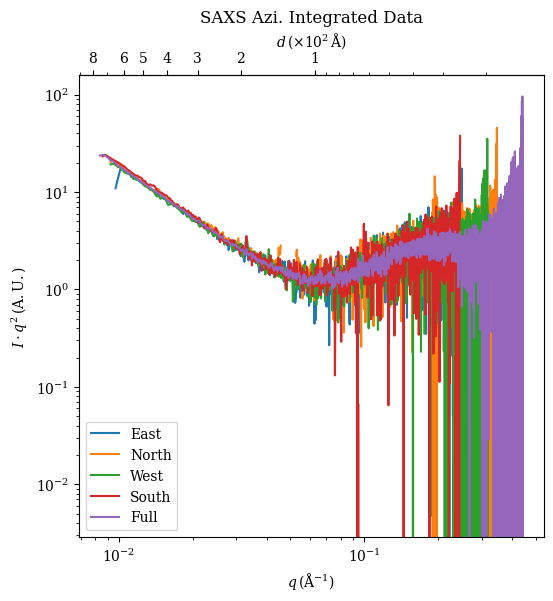

/tmp/ipykernel_2751951/4276303552.py:217: RuntimeWarning: Mean of empty slice
  np.nanmean(I_data[direction][20:30,0:30, :], axis=(0, 1)),


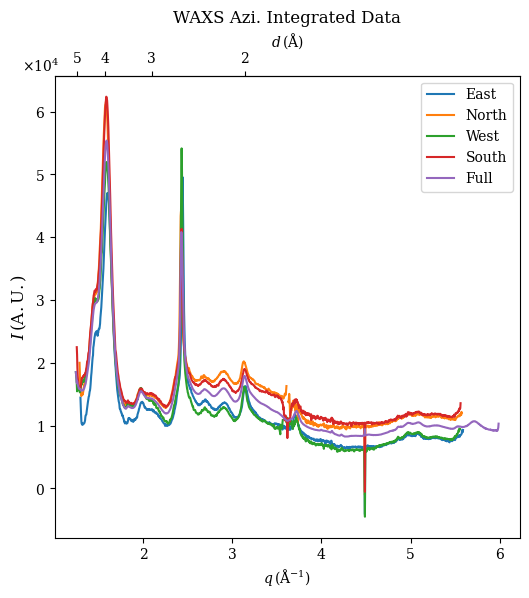

In [7]:
def azimuthal_integration(data, azi_min=0, azi_max=360):
    """
    Integrate (average) the intensity between the specified minimum azimuthal angle and the maximum one
    for all q. Handles azimuthal wrapping for ranges like 340° to 20°.

    Parameters
    ----------
    data : dict
        The data dictionary containing the keys 'I', 'q', 'azi', and 'norm'.
        - 'I' : Intensity data, shape (images, azimuthal angles, q).
        - 'q' : Radial q-vector for the integration (Å⁻¹).
        - 'azi' : Azimuthal angles in degrees (0 to 360).
        - 'norm' : Normalization weights for computing averages.

    azi_min : float, optional
        The minimum azimuthal angle for the integration range in degrees (default is 0°).
    azi_max : float, optional
        The maximum azimuthal angle for the integration range in degrees (default is 360°).

    Returns
    -------
    I_azimuthal_integrated : ndarray
        The intensity integrated over the specified azimuthal range for all q.

        - If `data['I']` has 3 dimensions, the result has shape (images, q).
        - If `data['I']` has 4 dimensions, the result has shape (rows, columns, q).

    Notes
    -----
    - Handles wraparound cases where azi_min > azi_max (e.g., 340° to 20°).
    - Uses safe division to avoid division by zero when normalization weights are zero.
    """
    I = data["I"]
    q = data["q"]
    azi = data["azi"]
    w = data["norm"]
    trans = data["i_t"]

    if azi_min > azi_max:  # Handle wraparound
        # Split into two ranges: [azi_min, 360°] and [0°, azi_max]
        idx_range1 = np.where(azi >= azi_min)[0]
        idx_range2 = np.where(azi < azi_max)[0]
        idx_range = np.concatenate([idx_range1, idx_range2])
    else:
        # Regular case
        idx_range = np.where((azi >= azi_min) & (azi < azi_max))[0]

    #Filter the data to includes only the relevant azimuthal angles
    I_azi = I[...,idx_range,:]
    w_azi = w[idx_range]


    # Sum of the weights across all considered azi angles
    norm_sum = np.sum(w_azi, axis=0)  

    # Mask norm_sum where it's zero
    norm_sum_safe = np.where(norm_sum == 0, np.nan, norm_sum)  # Replace zeros with NaN

    ndim = len(np.shape(I))  # So that it works on either original data, or reshaped
    if ndim == 3:
        I_times_norm = I_azi * w_azi[None, :, :]  # Weighted measurements
        I_azi_integrated = np.sum(I_times_norm, axis=1) / norm_sum_safe[None, :]
        I_azi_integrated = I_azi_integrated / trans[:,None]
    elif ndim == 4:
        I_times_norm = I_azi * w_azi[None, None, :, :]  # Weighted measurements
        I_azi_integrated = np.sum(I_times_norm, axis=2) / norm_sum_safe[None, None, :]
        I_azi_integrated = I_azi_integrated / trans[:,:,None]
    else:
        raise ValueError("Incompatible number of dimensions for the intensity")

    # Optionally replace NaN with zeros or another default value
    #I_azi_integrated = np.nan_to_num(I_azi_integrated, nan=0.0)

    return I_azi_integrated

def get_background_noise(I_data, method, shape):
    """
    Identifies background noise rows and calculates the average background noise.

    Background rows are identified by comparing the mean intensity of each row to the mean intensity
    of the middle row. Rows diverging beyond a predefined threshold (based on the scattering method)
    are considered background rows.

    Parameters
    ----------
    I_data : ndarray
        Azimuthally integrated intensity data.
        - If reshaped: Shape is (rows, cols, q), where `rows` and `cols` represent the sample layout.
        - If not reshaped: Shape is (image_idx, q), where `image_idx` follows a snake scan order.
    method : str
        Scattering method used, either 'SAXS' or 'WAXS'. Determines the background threshold:
        - 'SAXS': Threshold is 1500.
        - 'WAXS': Threshold is 9000.
        Note: these should be changed if the function does not behave as expected.
    shape : tuple or str
        Layout of the sample:
        - If "reshaped", the input `I_data` is assumed to be reshaped (rows, cols, q).
        - If tuple, specifies the shape of the snake scan as (rows, cols).

    Returns
    -------
    background_noise : ndarray
        Vector representing the mean background noise for each `q` value (shape: `(q,)`).
    """
    
    if method == 'SAXS':
        background_threshold = 1500
    elif method == 'WAXS':
        background_threshold = 9000
    else:
        print('Invalid scattering method')

    background_rows = []
    background_pixels = []
    which_rows = []
    
    if shape == "reshaped":
        num_rows, num_cols = I_data.shape[:2]
        middle_row_mean = np.nanmean(I_data[30], axis=(0, 1))
        
        for i in range(num_rows):
            row_mean = np.nanmean(I_data[i], axis=(0, 1))
            if (middle_row_mean - row_mean) > background_threshold:
                which_rows.append(i)
                q_wise_row_mean = np.nanmean(I_data[i], axis=0)
                background_rows.append(q_wise_row_mean)
                background_pixels.extend([(i, j) for j in range(num_cols)])
    else:
        num_rows, num_cols = shape
        middle_row_start = (num_rows // 2) * num_cols
        middle_row_end = middle_row_start + num_cols
        middle_row_mean = np.nanmean(I_data[middle_row_start:middle_row_end], axis=(0, 1))

        for i in range(num_rows):
            row_start = i * num_cols
            row_end = row_start + num_cols
            row_mean = np.nanmean(I_data[row_start:row_end], axis=(0, 1))
            if (middle_row_mean - row_mean) > background_threshold:
                which_rows.append(i)
                q_wise_row_mean = np.nanmean(I_data[i * num_cols : i * num_cols + num_cols], axis=0)
                background_rows.append(q_wise_row_mean)
                background_pixels.extend([(i, j) for j in range(num_cols)])

    if background_rows:
        background_noise = np.nanmean(background_rows, axis=0)
    else:
        raise ValueError("No background rows identified based on the threshold.")

    return background_noise, background_pixels

def plot_azimuthal_integrated_data(q_data, I_data, directions, method, row_range, col_range):
    """
    Plot azimuthal integrated intensity for all specified directions for SAXS and WAXS,
    with an additional x-axis for d = 2pi/q.

    Parameters
    ----------
    q_data : numpy.ndarray
        q-values for data.
    I_data : dict
        Dictionary containing radially integrated intensity the data, keyed by direction.
    directions : list
        List of directions to plot (e.g., ['east', 'north', 'west', 'south', 'full']).
    method : str
        Scattering method used (SAXS or WAXS).
    row_range : tuple or int, optional
        If a tuple, specifies the range of rows to use (start_row, end_row).
        If an int, specifies a single row. Default is None.
    col_range : tuple or int, optional
        If a tuple, specifies the range of columns to use (start_col, end_col).
        If an int, specifies a single column.
    """
    # Set up for slicing
    if isinstance(row_range, int):
        row_start, row_end = row_range, row_range + 1
    else:
        row_start, row_end = row_range
    
    if isinstance(col_range, int):
        col_start, col_end = col_range, col_range + 1
    else:
        col_start, col_end = col_range
        
    # Convert specified scattering method to uppercase
    method_upper = method.upper()

    if method_upper == 'SAXS':
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111)
        for direction in directions:
            ax.plot(
                q_data,
                np.nanmean(I_data[direction][row_start:row_end, col_start:col_end, :], axis=(0, 1)) * q_data ** 2,
                label=direction.capitalize()
            )
        
        ax.set_title(f"SAXS Azi. Integrated Data")
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel(r"$q \, (\mathrm{\AA}^{-1})$")
        ax.set_ylabel(r"$I \cdot q^2 \, (\mathrm{A.U.})$")
        ax.legend()

        # Add secondary x-axis for d
        secax = ax.secondary_xaxis('top', functions = (q_to_d, d_to_q))
        secax.set_xticks([100, 200, 300, 400, 500, 600, 800, 1000])
        secax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x / 100)}"))
        secax.xaxis.offsetText.set_visible(False)                                      # Hide the default offset
        secax.set_xlabel(r"$d \, (\times 10^2 \, \mathrm{\AA})$")
        
    elif method_upper == 'WAXS':
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111)
        for direction in directions:
            ax.plot(
                q_data,
                np.nanmean(I_data[direction][20:30,0:30, :], axis=(0, 1)),
                label=direction.capitalize()
        )
        ax.set_title("WAXS Azi. Integrated Data")
        ax.set_xlabel(r"$q \, (\mathrm{\AA}^{-1})$")
        ax.set_ylabel(r"$I \, (\mathrm{A.U.})$")
        ax.legend()

        # Set y-axis to scientific notation
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
        ax.yaxis.get_offset_text().set_fontsize(10)
        ax.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
        ax.set_ylabel(r"$I \, (\mathrm{A.U.})$", fontsize=12)

        # Adjust the position of the scientific notation offset label
        ax.yaxis.offsetText.set_x(-0.07)  # Adjust X-position

        # Add secondary x-axis for d
        secax = ax.secondary_xaxis('top', functions = (q_to_d, d_to_q))
        secax.set_xlabel(r"$d \, (\mathrm{\AA})$")
        secax.set_xticks([1, 2, 3, 4, 5])

    else:
        raise ValueError("Invalid scattering method.")

    plt.show()

# Define azimuthal slices
slices = {
    'east': (340, 20),    # Wraparound slice from 340° to 20°
    'north': (70, 110),   # From 70° to 110°
    'west': (160, 200),   # From 160° to 200°
    'south': (250, 290),  # From 250° to 290°
    'full': (0, 360)      # Entire range
}

directions = list(slices.keys())

# Perform azimuthal integration on background subtracted data for specified directions
print(f'Performing azimuthal integration...')
I_saxs_azi_integrated = {}
I_waxs_azi_integrated = {}
for direction, (azi_min, azi_max) in slices.items():
    I_saxs_azi_integrated[direction] = azimuthal_integration(saxs_data, azi_min=azi_min, azi_max=azi_max)
    I_waxs_azi_integrated[direction] = azimuthal_integration(waxs_data, azi_min=azi_min, azi_max=azi_max)

print(f'Azimuthal integration done to:')
print(f'dict: I_saxs_azi_integrated with keys: %s.' %directions)
print(f'dict: I_waxs_azi_integrated dict with keys: %s.' %directions)
print()

# Using the full integration, get the background noise vector and subtract from all rows.
saxs_background, saxs_background_pixels = get_background_noise(I_saxs_azi_integrated['full'], 'SAXS', 'reshaped')
waxs_background, waxs_background_pixels = get_background_noise(I_waxs_azi_integrated['full'], 'WAXS', 'reshaped')

for direction in slices.keys():
    I_saxs_azi_integrated[direction] = I_saxs_azi_integrated[direction] - saxs_background
    I_waxs_azi_integrated[direction] = I_waxs_azi_integrated[direction] - waxs_background
print('Background noise removed.')

# Extract q_data
q_saxs = saxs_data["q"]
q_waxs = waxs_data["q"]

# Plot
print('Plotting...')
print('Ignore the error messages :)')
plot_azimuthal_integrated_data(q_saxs, I_saxs_azi_integrated, directions, 'SAXS', image_coord[0], image_coord[1])
plot_azimuthal_integrated_data(q_waxs, I_waxs_azi_integrated, directions, 'WAXS', image_coord[0], image_coord[1])


## 3.2 Determine symmetry
While from visual inspection you might see some differences above between the different directions, it would be nice to quantify the difference somehow. One way of doing that is to integrate the azimuthal integrated data across some $q$-range. We then reduce the intensity to one value for each direction.

Let use the full $q$-range and compare:

- north vs. south
- east vs. west
- vertical vs. horizontal

By the ratios:

- $\alpha_{ns} = \bar{I}_{north} / \bar{I}_{south}$
- $\alpha_{ew} = \bar{I}_{east} / \bar{I}_{west}$
- $\alpha_{vh} = \bar{I}_{vert} / \bar{I}_{horz}$

Values close to 1 signify symmetry betwen the compared directions.

In [8]:
def calculate_symmetry_ratios(q_data, I_data, directions, ratios, method, row_range, col_range, q_range="full"):
    """
    Calculate symmetry ratios for given azimuthally integrated data and direction pairs.

    Parameters
    ----------
    q_data : numpy.ndarray
        q-values for data.
    I_data : dict
        Dictionary containing az integrated intensity data, keyed by direction.
    directions : list
        List of directions to include (e.g., ['east', 'north', 'west', 'south']).
    ratios : dict
        Dictionary specifying direction pairs for symmetry ratio calculations.
        E.g., {'ns': ('north', 'south'), 'ew': ('east', 'west')}.
    q_range : tuple or str, optional
        Tuple specifying the q-range for averaging (q_min, q_max).
        If "full", takes the entire q-range for averaging. Default is "full".
    row_range : tuple or int
        If a tuple, specifies the range of rows to use (start_row, end_row).
        If an int, specifies a single row.
    col_range : tuple or int, optional
        If a tuple, specifies the range of columns to use (start_col, end_col).
        If an int, specifies a single column.
    method : str, optional
        Scattering method ('SAXS' or 'WAXS'), used for reporting purposes. Default is 'SAXS'.

    Returns
    -------
    symmetry_ratios : dict
        Dictionary containing symmetry ratios for each pair of directions.
    """
    # Determine q-range indices
    if q_range == "full":
        q_indices = np.arange(len(q_data))
    else:
        q_min, q_max = q_range
        q_indices = np.where((q_data >= q_min) & (q_data <= q_max))[0]
    
    # Set up for slicing
    if isinstance(row_range, int):
        row_start, row_end = row_range, row_range + 1
    else:
        row_start, row_end = row_range
    
    if isinstance(col_range, int):
        col_start, col_end = col_range, col_range + 1
    else:
        col_start, col_end = col_range

    # Compute symmetry ratios
    symmetry_ratios = {}
    for ratio, (dir1, dir2) in ratios.items():
        if ratio == 'vh':
            # Special case: vertical-horizontal symmetry ratio
            numerator = (
                np.nanmean(I_data['east'][row_start:row_end, col_start:col_end, q_indices], axis=(0, 1, 2)) +
                np.nanmean(I_data['west'][row_start:row_end, col_start:col_end, q_indices], axis=(0, 1, 2))
            )
            denominator = (
                np.nanmean(I_data['north'][row_start:row_end, col_start:col_end, q_indices], axis=(0, 1, 2)) +
                np.nanmean(I_data['south'][row_start:row_end, col_start:col_end, q_indices], axis=(0, 1, 2))
            )
            symmetry_ratios[ratio] = numerator / denominator
        else:
            # General case for other symmetry ratios
            numerator = np.nanmean(I_data[dir1][row_start:row_end, col_start:col_end, q_indices], axis=(0, 1, 2))
            denominator = np.nanmean(I_data[dir2][row_start:row_end, col_start:col_end, q_indices], axis=(0, 1, 2))
            symmetry_ratios[ratio] = numerator / denominator


    # Print results
    print(f"Symmetry ratios for {method} data:")
    for ratio, value in symmetry_ratios.items():
        print(f"{ratio.upper()} symmetry ratio = {value:.6f}")

    return symmetry_ratios

ratios = {
    'ns': ('east', 'west'),
    'ew': ('north', 'south'),
    'vh': ('northsouth', 'eastwest'),
}

# Calculate SAXS symmetry ratios
symmetry_ratios_saxs = calculate_symmetry_ratios(
    q_saxs, I_saxs_azi_integrated, directions, ratios, 'SAXS', image_coord[0], image_coord[1]
)

# Calculate WAXS symmetry ratios
symmetry_ratios_waxs = calculate_symmetry_ratios(
    q_waxs, I_waxs_azi_integrated, directions, ratios, 'WAXS', image_coord[0], image_coord[1]
)


Symmetry ratios for SAXS data:
NS symmetry ratio = 1.103791
EW symmetry ratio = 0.560444
VH symmetry ratio = 0.766777
Symmetry ratios for WAXS data:
NS symmetry ratio = 0.923014
EW symmetry ratio = 0.983790
VH symmetry ratio = 0.809474


# 4 Curve fitting
The intensity data for single images can be quite volatile, to simplify analysis it can be good to perform some kind of smoothing of the data. Also, all peaks are not of interest. Using curve fitting techniques such as Fourier or Gaussian can aid this. Further, it can help reduce the data further by identifying for which $q$ (or $d$) we find peaks, as well as information about the width of the peak. These kind of summary statistics can be used when comparing a large collection of samples using e.g. statistical hypotheses testing.

The rest of this chapter we will examine three pixels. However, the code is written such that any number of pixels can be entered for the analysis. Define the pixels (row, column) that you wish to examine. The count starts at (0, 0) in the upper left corner.

The plot of the sample images show which pixels are selected, here the intensity is averaged across all azimuthal angles and $q$-values. 

### 4.1.1 Plot data without background noise



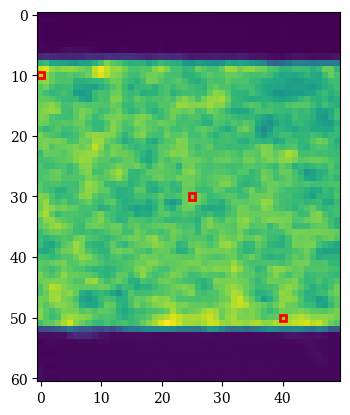

In [9]:
image_coords = [(30, 25), (10, 0), (50, 40)]
I_waxs_azi_full = I_waxs_azi_integrated["full"]
I_avg = np.nanmean(I_waxs_azi_full, axis=(2))

plt.imshow(I_avg)
ax = plt.gca()

for i in range(len(image_coords)):
    x = image_coords[i][1]
    y = image_coords[i][0]
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, color='red', linewidth=2)
    ax.add_patch(rect)
    
plt.show()

Now lets inspect the intensity plots for each of the background corrected pixels.

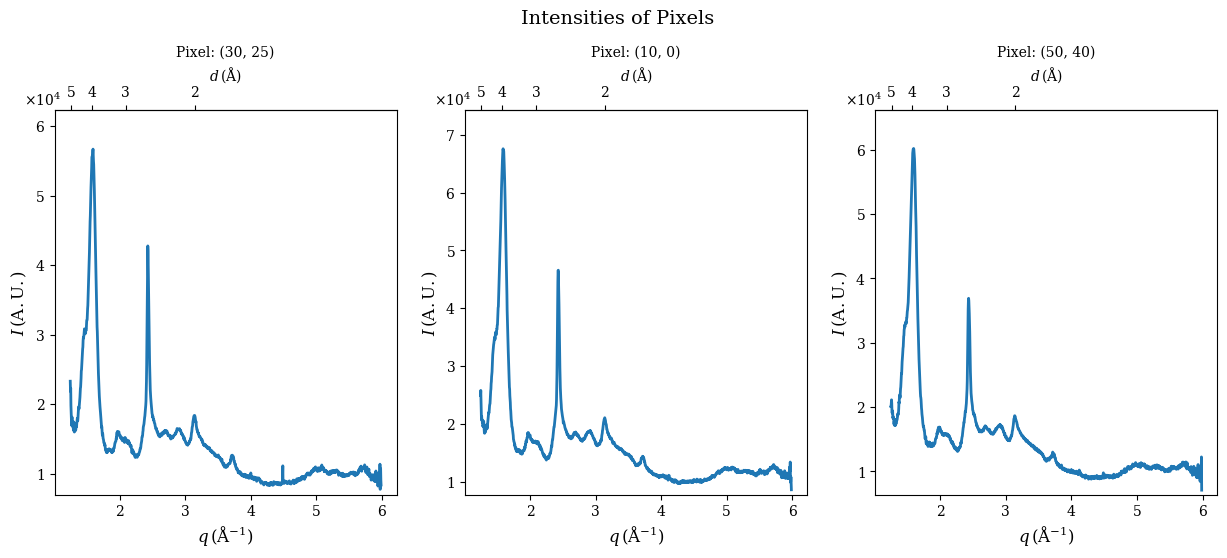

In [10]:
fig, ax = plt.subplots(1, len(image_coords), figsize=(15, 5))
fig.suptitle('Intensities of Pixels', y=1.08, fontsize=14)

for i, coord in enumerate(image_coords):
    y_min, y_max = calculate_y_limits(I_waxs_azi_full[coord[0], coord[1], :])
    ax[i].set_ylim(y_min, y_max)

    # Plot the intensities
    ax[i].plot(q_waxs, I_waxs_azi_full[coord[0], coord[1], :], linewidth=2)
    ax[i].set_title(f'Pixel: ({coord[0]}, {coord[1]})', fontsize=10)
    ax[i].set_xlabel(r"$q \, (\mathrm{\AA}^{-1})$", fontsize=12)
    

    # Set y-axis with scientific notation
    ax[i].yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
    ax[i].yaxis.get_offset_text().set_fontsize(10)
    ax[i].ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax[i].set_ylabel(r"$I \, (\mathrm{A.U.})$", fontsize=12)

    # Adjust the position of the scientific notation offset label
    ax[i].yaxis.offsetText.set_x(-0.09)  # Adjust X-position
    
    # Set secondary x-axis for d values
    secax = ax[i].secondary_xaxis('top', functions = (q_to_d, d_to_q))
    secax.set_xlabel(r"$d \, (\mathrm{\AA})$")
    secax.set_xticks([1, 2, 3, 4, 5])

plt.show()

## 4.3 Fit nosie free data (Fourier)
In the next step we will try to find the peaks of each pixel's plot.

To find the peaks we first filter the intensity data to smoothen the curve to easier find the "real" peaks and not just noise. For this we use the `scipy.signal` library method `medfilt`. The parameter `kernel_size` specifies how much the data should be smoothened and must be set by the user. (I saw that Edvin used another method for this, I don't know which one is best.)

The next step is to find the actual peaks. We continue to use the `scipy.signal` library but with the method `find_peaks`. This method takes a bunch of different optional parameters to tune the search. I have just tried some randomly and found that these two seems to work reasonably well.

This step is to be able to tweak the parameters. When we are happy with the peaks found for the pixels we will move on to examine the full sample. 


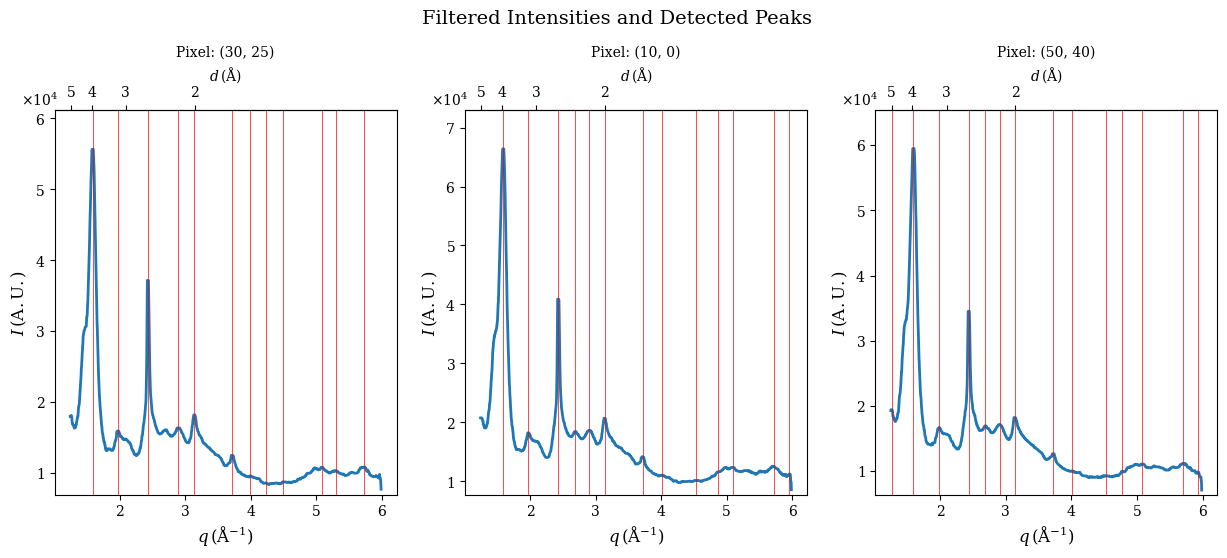

In [11]:
def filter_and_find_peaks(q_data, intensity_data, pixels, kernel_size=11, distance=60, width=4):
    """
    Filters intensity data and identifies peaks for specified pixels.

    Parameters
    ----------
    q_data : np.ndarray
        Array of q-values (Å⁻¹).
    intensity_data : np.ndarray
        Array of intensity values for each pixel.
    pixels : list
        List of pixel indices to process.
    kernel_size : int, optional
        Kernel size for median filtering (default: 11).
    distance : int, optional
        Minimum distance between peaks for peak detection (default: 60).
    width : int, optional
        Minimum width of peaks for peak detection (default: 4).

    Returns
    -------
    dict
        Dictionary containing filtered intensities and peak indices for each pixel.
    """
    # Filter intensities using median filter
    I_filtered = [signal.medfilt(intensity_data[pixel], kernel_size) for pixel in pixels]

    # Identify peaks in filtered data
    peak_indices = [
        signal.find_peaks(filtered_intensity, distance=distance, width=width)[0]
        for filtered_intensity in I_filtered
    ]

    # Plot results
    fig, ax = plt.subplots(1, len(pixels), figsize=(15, 5))
    fig.suptitle(r'Filtered Intensities and Detected Peaks', y=1.08, fontsize=14)

    for i, pixel in enumerate(pixels):
        # Set secondary x-axis for d values
        secax = ax[i].secondary_xaxis('top', functions = (q_to_d, d_to_q))
        secax.set_xlabel(r"$d \, (\mathrm{\AA})$")
        secax.set_xticks([1, 2, 3, 4, 5])
        ax[i].set_xlabel(r"$q \, (\mathrm{\AA}^{-1})$", fontsize=12)

        # Calculate individual y-axis limits with padding
        y_min, y_max = calculate_y_limits(I_filtered[i])
        ax[i].set_ylim(y_min, y_max)

        # Set y-axis to scientific notation
        ax[i].yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
        ax[i].yaxis.get_offset_text().set_fontsize(10)
        ax[i].ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
        ax[i].set_ylabel(r"$I \, (\mathrm{A.U.})$", fontsize=12)

        # Adjust the position of the scientific notation offset label
        ax[i].yaxis.offsetText.set_x(-0.10)  # Adjust X-position

        # Plot the filtered intensity and detected peaks
        ax[i].plot(q_data, I_filtered[i], linewidth=2)
        for xc in peak_indices[i]:
            ax[i].axvline(x=q_data[xc], ymin=0, ymax=1, c='r', lw=0.5)

        # Add a subplot title
        ax[i].set_title(f'Pixel: ({pixel[0]}, {pixel[1]})', fontsize=10)

    plt.show()

    return {"filtered_intensities": I_filtered, "peak_indices": peak_indices}


# Perform filtering and peakfinding
result = filter_and_find_peaks(q_waxs, I_waxs_azi_full, image_coords)


Now that we have found parameters that seem to find the peaks we are interested in for a few samples we will apply it to the whole sample. This will give us some idea of how the intensity plot shape is varied across the sample. If the number of peaks found is consistent we should have more confidence to use the sample average when analyzing the intensity peaks.

In this section we create a dictionary `number_of_peaks` on the form `{int, array[int]}` where the key are the number of peaks found and the corresponding value an array stores the image indices. This allows for further inspection of pixels that diverge from the rest of the sample.

Note that we only calculate the number of peaks of pixels that are not in the background.

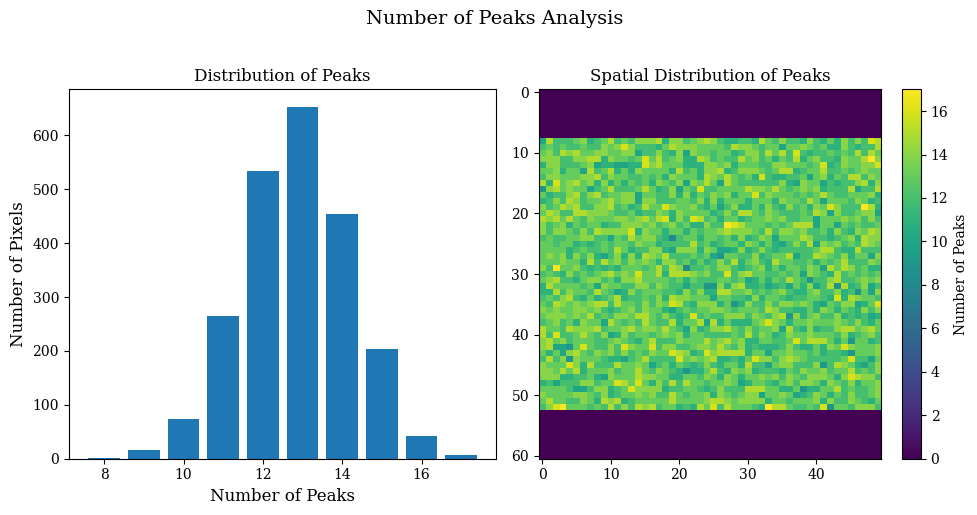

In [12]:
def analyze_num_peaks(intensity_data, background_pixels, kernel_size=11, distance=60, width=4):
    """
    Analyzes the number of peaks detected for each pixel, excluding background pixels.

    Parameters
    ----------
    intensity_data : ndarray
        Array of intensity values, shape (rows, cols, q).
    background_pixels : list
        List of pixel indices (row, col) to exclude from analysis.
    kernel_size : int
        Kernel size for median filtering.
    distance : int
        Minimum distance between peaks for peak detection.
    width : int
        Minimum width of peaks for peak detection.

    Returns
    -------
    dict
        Dictionary with the number of peaks as keys and lists of pixel indices as values.
    ndarray
        Array with the number of peaks found for each pixel, shape (rows, cols).
    """
    num_rows, num_cols, _ = intensity_data.shape
    num_peaks = {}
    peaks_found = np.zeros((num_rows, num_cols))  # Initialize array for peak counts

    for row in range(num_rows):
        for col in range(num_cols):
            if (row, col) in background_pixels:
                continue

            # Extract 1D intensity data for the current pixel
            intensity_1d = intensity_data[row, col, :]

            # Apply median filter and find peaks
            filtered_intensity = signal.medfilt(intensity_1d, kernel_size)
            peak_indices = signal.find_peaks(filtered_intensity, distance=distance, width=width)[0]
            num_found = len(peak_indices)

            # Update dictionary and peaks array
            if num_found not in num_peaks:
                num_peaks[num_found] = []
            num_peaks[num_found].append((row, col))
            peaks_found[row, col] = num_found

    return num_peaks, peaks_found


# Usage example:
num_peaks, peaks_found_reshaped = analyze_num_peaks(
    I_waxs_azi_full,
    waxs_background_pixels,
)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Number of Peaks Analysis", y=1.02, fontsize=14)

# Bar plot for the distribution of the number of peaks
bar_plot = [len(pixels) for pixels in num_peaks.values()]
ax1.bar(num_peaks.keys(), bar_plot)
ax1.set_xlabel("Number of Peaks", fontsize=12)
ax1.set_ylabel("Number of Pixels", fontsize=12)
ax1.set_title("Distribution of Peaks", fontsize=12)

# Visualize the spatial distribution of peaks
im = ax2.imshow(peaks_found_reshaped, interpolation='none', aspect='auto', cmap='viridis')
ax2.set_title("Spatial Distribution of Peaks", fontsize=12)
plt.colorbar(im, ax=ax2, label="Number of Peaks")

plt.tight_layout()
plt.show()


Now that we see that the shape of the intensity plots seems to be consistent over the whole sample we will calculate the sample average for all rows except the background rows and find the $q$ indices of the peaks.

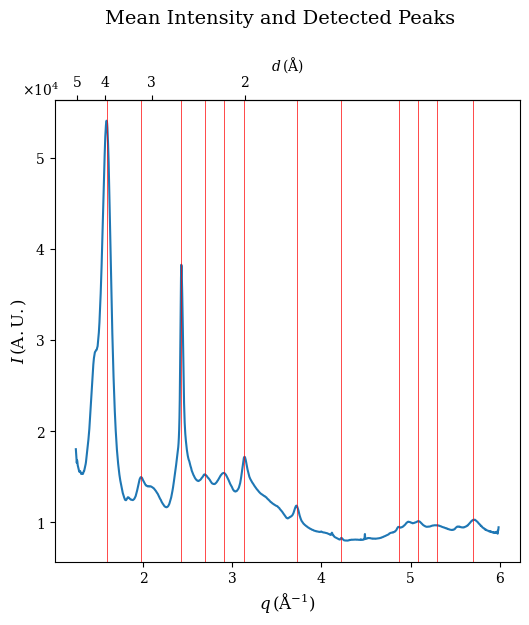

In [13]:
# Remove background rows and calculate the mean intensity over the remaining rows
rows_to_include = [
    row for row in range(I_waxs_azi_full.shape[0]) 
    if row not in [pixel[0] for pixel in waxs_background_pixels]
]
mean_intensity = np.mean(I_waxs_azi_full[rows_to_include, :, :], axis=(0, 1))

# Find the peaks in the mean intensity
peak_indices = signal.find_peaks(mean_intensity, distance=60, width=4)[0]
#print(f"Peaks: {peak_indices}")

# Plot the mean intensity and mark the detected peaks
plt.figure(figsize=(6, 6))
plt.plot(q_waxs, mean_intensity, label='Mean Intensity')
plt.suptitle('Mean Intensity and Detected Peaks', y=1.03, fontsize=14)
plt.xlabel(r"$q \, (\mathrm{\AA}^{-1})$", fontsize=12)
plt.ylabel(r"$I \, (\mathrm{A.U.})$", fontsize=12)

# Add secondary x-axis for d-values
ax = plt.gca()

# Set y-axis to scientific notation
ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
ax.yaxis.get_offset_text().set_fontsize(10)
ax.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
ax.set_ylabel(r"$I \, (\mathrm{A.U.})$", fontsize=12)

# Adjust the position of the scientific notation offset label
ax.yaxis.offsetText.set_x(-0.07)  # Adjust X-position

# Set secondary x-axis for d values
secax = ax.secondary_xaxis('top', functions = (q_to_d, d_to_q))
secax.set_xlabel(r"$d \, (\mathrm{\AA})$")
secax.set_xticks([1, 2, 3, 4, 5])

# Highlight the detected peaks
for xc in peak_indices:
    ax.axvline(x=q_waxs[xc], ymin=0, ymax=1, c='r', lw=0.5, label=f'Peak at {xc}')

plt.show()


In this section we will briefly apply some basic signal processing techniques to the intensity data.

We start by applying a Fourier transform to the mean signal acquired from the previous section. We use the library `scipy.fft` for the Fourier transform methods. The method `rfft` computes a 1-D Fourier transform of a real valued array.

The method `rfftfreq` is used to calculate sample frequencies which allows us to plot the transformed signal. 

Text(0.5, 0.98, 'Frequency Spectrum')

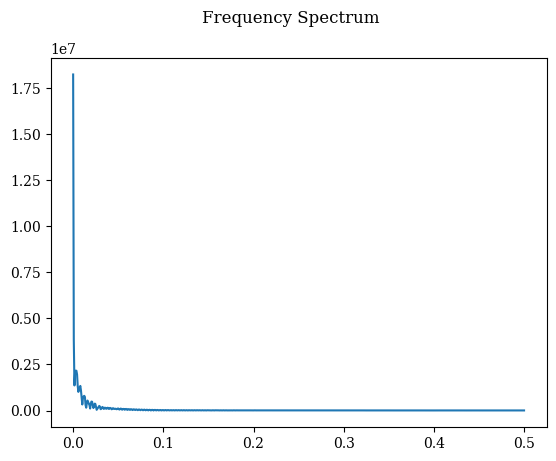

In [14]:
f_hat_dft = fft.rfft(mean_intensity)

frequencies = np.fft.rfftfreq(q_waxs.size)

plt.plot(frequencies, np.abs(f_hat_dft))
plt.suptitle('Frequency Spectrum')

We see that the largest amplitudes are for the low frequencies which indicates that the signal can be expressed with only a few frequencies.

Lets invert the transform with all data points and for some lower rank.

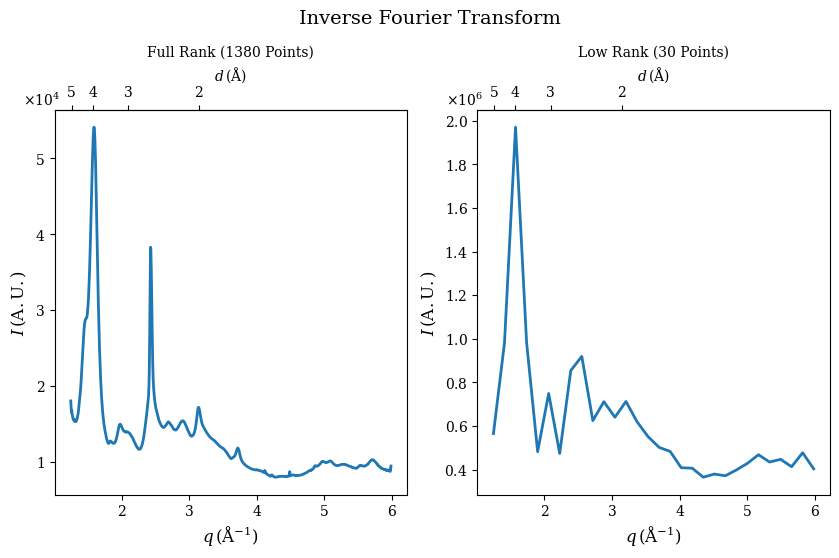

In [15]:
f_dft = fft.irfft(f_hat_dft)

low_rank = 30
f_dft_low_rank = fft.irfft(f_hat_dft, low_rank)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(r'Inverse Fourier Transform', y=1.08, fontsize=14)

# Full rank plot
q_full = np.linspace(np.min(q_waxs), np.max(q_waxs), f_dft.size)
ax1.plot(q_full, f_dft, linewidth=2)
ax1.set_title(f'Full Rank ({f_dft.size} Points)', fontsize=10)
ax1.set_xlabel(r"$q \, (\mathrm{\AA}^{-1})$", fontsize=12)
ax1.set_ylabel(r"$I \, (\mathrm{A.U.})$", fontsize=12)

# Set y-axis to scientific notation
ax1.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
ax1.yaxis.get_offset_text().set_fontsize(10)
ax1.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
ax1.set_ylabel(r"$I \, (\mathrm{A.U.})$", fontsize=12)

# Adjust the position of the scientific notation offset label
ax1.yaxis.offsetText.set_x(-0.09)  # Adjust X-position

# Set secondary x-axis for d values
secax1 = ax1.secondary_xaxis('top', functions = (q_to_d, d_to_q))
secax1.set_xlabel(r"$d \, (\mathrm{\AA})$")
secax1.set_xticks([1, 2, 3, 4, 5])

# Low rank plot
q_low = np.linspace(np.min(q_waxs), np.max(q_waxs), f_dft_low_rank.size)
ax2.plot(q_low, f_dft_low_rank, linewidth=2)
ax2.set_title(f'Low Rank ({f_dft_low_rank.size} Points)', fontsize=10)
ax2.set_xlabel(r"$q \, (\mathrm{\AA}^{-1})$", fontsize=12)
ax2.set_ylabel(r"$I \, (\mathrm{A.U.})$", fontsize=12)

# Set y-axis to scientific notation
ax2.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
ax2.yaxis.get_offset_text().set_fontsize(10)
ax2.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
ax2.set_ylabel(r"$I \, (\mathrm{A.U.})$", fontsize=12)

# Adjust the position of the scientific notation offset label
ax2.yaxis.offsetText.set_x(-0.09)  # Adjust X-position

# Set secondary x-axis for d values
secax2 = ax2.secondary_xaxis('top', functions = (q_to_d, d_to_q))
secax2.set_xlabel(r"$d \, (\mathrm{\AA})$")
secax2.set_xticks([1, 2, 3, 4, 5])

plt.show()

## 4.4 Fit nosie free data (Gaussian)
Using the average intensity data across all non-background pixels, we begin again by smoothing the data, this time using the savgol_filter from the scipy.signal library. After smoothing the data we find the peaks.

Once the peaks are identified, we fit Gaussian functions to model each peak. To improve numerical stability we rescale both the $q$-values and intensity to the range [0, 1].

The multi-gaussian model is defined as a sum of individual Gaussian components:

\begin{equation}
y(\boldsymbol{x}) = \sum_i A_i \cdot e{-\frac{(x-\mu_i)^2}{2\sigma_i^2}}, \tag{5}
\end{equation}

where $A_i$, $\mu_i$, and $\sigma_i$ is the amplitude, mean and standard deviation of the $i$-th Gaussian.

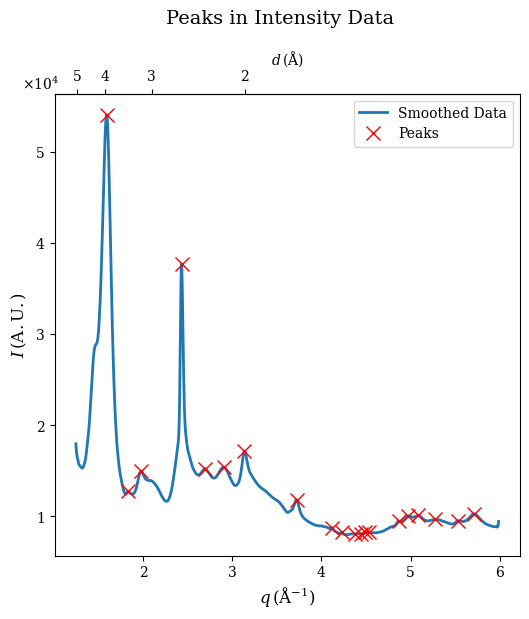

In [16]:
# Smooth the data to reduce noise
smoothed_y = savgol_filter(mean_intensity, window_length=11, polyorder=3)

# Find peaks
peaks, properties = find_peaks(smoothed_y, prominence=1, width=5)

# Plot the results
fig, ax = plt.subplots(figsize=(6, 6))
fig.suptitle(r"Peaks in Intensity Data", y=1.02, fontsize=14)

# Plot the smoothed intensity data
ax.plot(q_waxs, smoothed_y, label="Smoothed Data", linewidth=2)

# Highlight the detected peaks
ax.plot(q_waxs[peaks], smoothed_y[peaks], "x", label="Peaks", markersize=10, color='red')

# Axis labels and formatting
ax.set_xlabel(r"$q \, (\mathrm{\AA}^{-1})$", fontsize=12)
ax.set_ylabel(r"$I \, (\mathrm{A.U.})$", fontsize=12)

# Set y-axis to scientific notation
ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
ax.yaxis.get_offset_text().set_fontsize(10)
ax.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
ax.set_ylabel(r"$I \, (\mathrm{A.U.})$", fontsize=12)

# Adjust the position of the scientific notation offset label
ax.yaxis.offsetText.set_x(-0.07)  # Adjust X-position

# Set secondary x-axis for d values
secax = ax.secondary_xaxis('top', functions = (q_to_d, d_to_q))
secax.set_xlabel(r"$d \, (\mathrm{\AA})$")
secax.set_xticks([1, 2, 3, 4, 5])

# Add legend
ax.legend(fontsize=10, loc="best")

plt.show()

Number of Peaks to Fit: 10
Performing Gaussian Fit...
Fitted Parameters (Scaled):
Peak 1: Amplitude (A) = 0.0122, Mean (mu) = 0.0743, Std Dev (sigma) = 0.0084
Peak 2: Amplitude (A) = 0.0029, Mean (mu) = 0.2502, Std Dev (sigma) = 0.0029
Peak 3: Amplitude (A) = 0.0027, Mean (mu) = 0.7914, Std Dev (sigma) = 0.0338
Peak 4: Amplitude (A) = 0.0626, Mean (mu) = 0.0000, Std Dev (sigma) = 0.1721
Peak 5: Amplitude (A) = 0.0066, Mean (mu) = 0.9154, Std Dev (sigma) = 0.0889
Peak 6: Amplitude (A) = 0.0006, Mean (mu) = 0.9431, Std Dev (sigma) = 0.0116
Peak 7: Amplitude (A) = 0.0042, Mean (mu) = 0.2534, Std Dev (sigma) = 0.0118
Peak 8: Amplitude (A) = 0.0002, Mean (mu) = 0.8558, Std Dev (sigma) = 0.0098
Peak 9: Amplitude (A) = 0.0358, Mean (mu) = 0.3729, Std Dev (sigma) = 0.1045
Peak 10: Amplitude (A) = 0.0180, Mean (mu) = 0.0597, Std Dev (sigma) = 0.0198


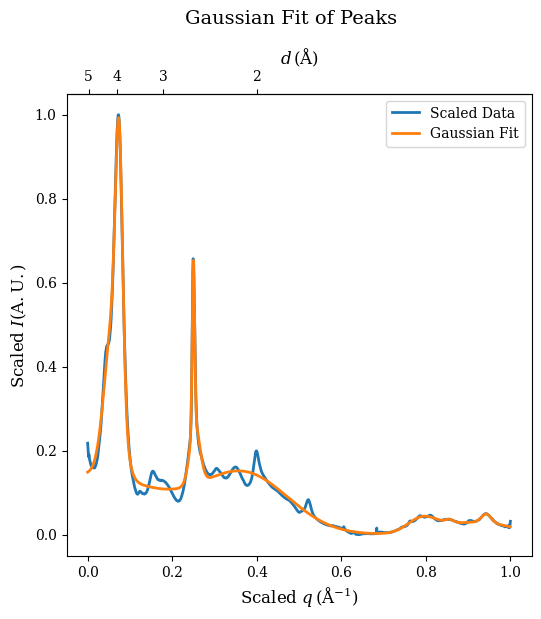

In [17]:
def gaussian_fit(q_values, average_intensity, max_peaks_to_fit=10, prominence=0.001, width=5):
    """
    Performs a Gaussian fit on average intensity data.

    Parameters
    ----------
    q_values : np.ndarray
        Array of q-values (Å⁻¹).
    mean_intensity : np.ndarray
        Array of average intensity values corresponding to q-values.
    max_peaks_to_fit : int, optional
        Maximum number of peaks to fit (default: 10).
    prominence : float, optional
        Prominence threshold for peak detection (default: 0.001).
    width : int, optional
        Minimum width of peaks for peak detection (default: 5).

    Returns
    -------
    np.ndarray
        Fitted parameters of the Gaussian model.
    """
    # Scale input data
    q_scaled = (q_values - np.min(q_values)) / (np.max(q_values) - np.min(q_values))
    intensity_scaled = (mean_intensity - np.min(mean_intensity)) / (np.max(mean_intensity) - np.min(mean_intensity))

    # Find peaks directly in the scaled data
    peak_indices, properties = find_peaks(intensity_scaled, prominence=prominence, width=width)
    num_peaks_to_fit = min(len(peak_indices), max_peaks_to_fit)
    print(f'Number of Peaks to Fit: {num_peaks_to_fit}')
    print(f'Performing Gaussian Fit...')

    # Sort peaks by prominence and select the top peaks
    sorted_indices = np.argsort(properties["prominences"])[::-1]
    selected_peaks = peak_indices[sorted_indices[:num_peaks_to_fit]]
    selected_prominences = properties["prominences"][sorted_indices[:num_peaks_to_fit]]
    selected_widths = properties["widths"][sorted_indices[:num_peaks_to_fit]]

    # Construct initial guesses
    initial_guess = []
    for i in range(num_peaks_to_fit):
        A = selected_prominences[i]
        mu = q_scaled[selected_peaks[i]]
        sigma = selected_widths[i] / (2.355 * (q_scaled[1] - q_scaled[0]))
        initial_guess.extend([A, mu, sigma])

    # Define the Gaussian model
    def multi_gaussian(x, *params):
        y = np.zeros_like(x)
        for i in range(0, len(params), 3):
            A, mu, sigma = params[i:i + 3]
            y += A * norm.pdf(x, loc=mu, scale=sigma)
        return y

    # Set bounds
    lower_bounds = [0, 0, 0] * num_peaks_to_fit
    upper_bounds = [2 * max(intensity_scaled), 1.0, 0.2] * num_peaks_to_fit
    initial_guess = np.clip(initial_guess, lower_bounds, upper_bounds)

    # Fit the Gaussian model to the data
    try:
        popt, _ = curve_fit(
            multi_gaussian, q_scaled, intensity_scaled,
            p0=initial_guess, bounds=(lower_bounds, upper_bounds), maxfev=1000
        )
    except RuntimeError as e:
        print("Fit failed:", e)
        popt = initial_guess  # Use initial guess if fit fails
        
    print("Fitted Parameters (Scaled):")
    for i in range(num_peaks_to_fit):
        A, mu, sigma = popt[i*3:(i+1)*3]
        print(f"Peak {i+1}: Amplitude (A) = {A:.4f}, Mean (mu) = {mu:.4f}, Std Dev (sigma) = {sigma:.4f}")
    return popt, q_scaled, intensity_scaled, multi_gaussian

fitted_params, q_scaled, intensity_scaled, multi_gaussian = gaussian_fit(
    q_waxs,
    mean_intensity,
)

# Plot the results
fig, ax = plt.subplots(figsize=(6, 6))
fig.suptitle("Gaussian Fit of Peaks", y=1.02, fontsize=14)

# Plot scaled data
ax.plot(q_scaled, intensity_scaled, label="Scaled Data", linewidth=2)

# Plot Gaussian fit
ax.plot(q_scaled, multi_gaussian(q_scaled, *fitted_params), label="Gaussian Fit", linewidth=2)

# Axis labels and legend
ax.set_xlabel(r"Scaled $q \, (\mathrm{\AA}^{-1})$", fontsize=12)
ax.set_ylabel(r"Scaled $I(\mathrm{A.U.})$", fontsize=12)
ax.legend(fontsize=10, loc="best")

# Set secondary x-axis for d values
secax = ax.secondary_xaxis(
    'top',
    functions=(lambda q: q_to_d(q * (np.max(q_waxs) - np.min(q_waxs)) + np.min(q_waxs)),
               lambda d: (d_to_q(d) - np.min(q_waxs)) / (np.max(q_waxs) - np.min(q_waxs)))
)
secax.set_xlabel(r"$d \, (\mathrm{\AA})$", fontsize=12)
secax.set_xticks([1, 2, 3, 4, 5])


plt.show()